In [86]:
import numpy as np
import pandas as pd

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.model_selection import GridSearchCV

from sklearn.inspection import permutation_importance
import plotly.express as px
import matplotlib.pyplot as plt

### Load Data

In [62]:
df_x = pd.read_csv('./processed_train_x.csv')
df_y = pd.read_csv('./processed_train_y.csv')
data_x = np.array(df_x)
data_y = np.array(df_y).reshape(-1)
x_train, x_test, y_train, y_test = train_test_split(data_x,data_y,random_state = 28)

In [33]:
print("x_train shape: " + str(x_train.shape))
print("x_test shape: " + str(x_test.shape))

x_train shape: (1093, 221)
x_test shape: (365, 221)


### Build Model and Search Parameters

In [ ]:
# parameters default value
# learning_rate = 0.1
# n_estimators = 100
# min_samples_split = 2
# min_samples_leaf = 1
# max_depth = 3

In [36]:
def explore(param_grid):
    gbm = GradientBoostingRegressor()
    clf = GridSearchCV(gbm, param_grid = param_grid,scoring = 'neg_mean_squared_error')
    clf.fit(x_train,  y_train)
    return clf
def plot_pf(clf,para_name):
    clf.cv_results_['mean_test_score']
    plt.plot((param_grid[para_name]),clf.cv_results_['mean_test_score'],marker='o', markerfacecolor='blue', markersize=7, color='skyblue', linewidth=4)
    plt.ylabel('neg_mean_squared_error')
    plt.xlabel(para_name)
    plt.show()
    print("Best: " + str(clf.best_params_))

#### Learning_rate

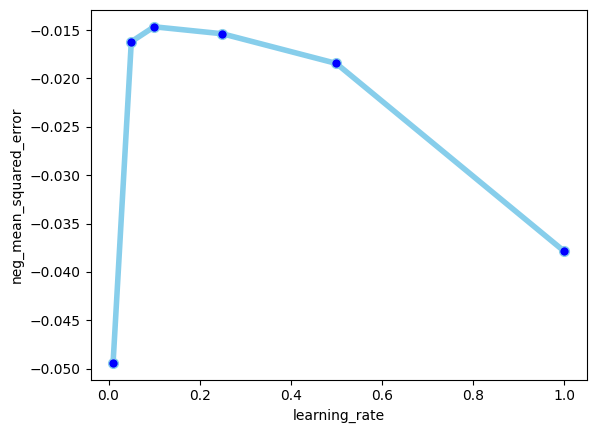

Best: {'learning_rate': 0.1, 'random_state': 28}


In [40]:
param_grid = {
        'learning_rate': [1, 0.5, 0.25, 0.1, 0.05, 0.01],
        'random_state' :[28]
    }
clf = explore(param_grid)
plot_pf(clf,'learning_rate')

#### N_estimators

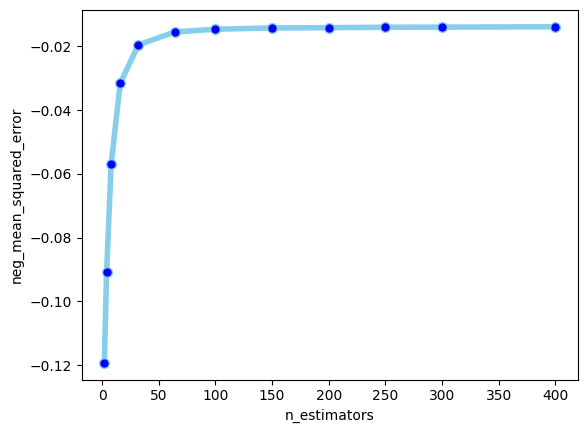

Best: {'n_estimators': 400, 'random_state': 28}


In [41]:
param_grid = {
        'n_estimators': [2, 4, 8, 16, 32, 64, 100, 150,200,250,300,400],
        'random_state' :[28]
    }
clf = explore(param_grid)
plot_pf(clf,'n_estimators')

#### Max_depth

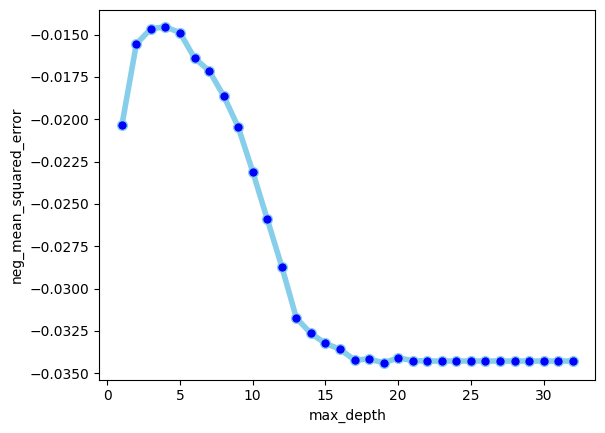

Best: {'max_depth': 4.0, 'random_state': 28}


In [42]:
md = np.linspace(1, 32, 32, endpoint=True)
param_grid = {
        'max_depth': md,
        'random_state' :[28]
    }
clf = explore(param_grid)
plot_pf(clf,'max_depth')

#### Min_samples_split

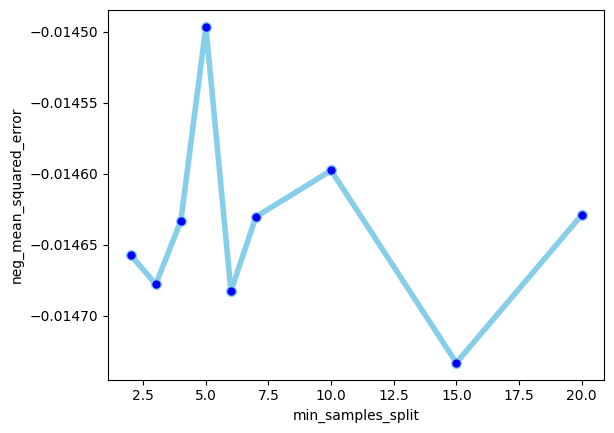

Best: {'min_samples_split': 5, 'random_state': 28}


In [43]:
min_samples_splits = [2,3,4,5,6,7,10,15,20]
param_grid = {
        'min_samples_split': min_samples_splits,
        'random_state' :[28]
    }
clf = explore(param_grid)
plot_pf(clf,'min_samples_split')


#### Min_samples_leaf

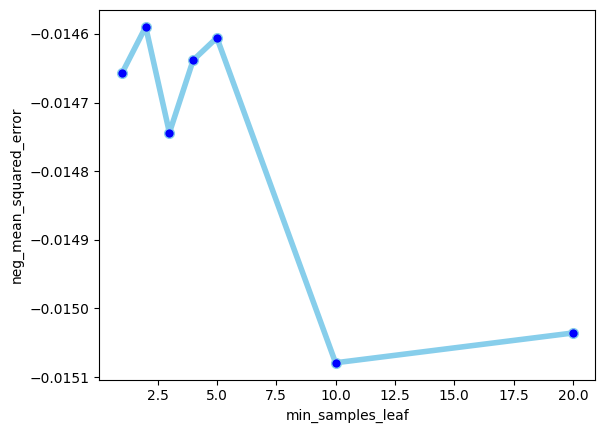

Best: {'min_samples_leaf': 2, 'random_state': 28}


In [44]:
min_samples_leafs = [1,2,3,4,5,10,20]
param_grid = {
        'min_samples_leaf': min_samples_leafs,
        'random_state' :[28]
    }
clf = explore(param_grid)
plot_pf(clf,'min_samples_leaf')

In [99]:
gbm = GradientBoostingRegressor(
        learning_rate = 0.1,
        n_estimators = 300,
        min_samples_split = 5,
        min_samples_leaf = 2,
        max_depth = 4
    )

In [100]:
gbm.fit(x_train,y_train)
-mean_squared_error(gbm.predict(x_test),y_test)

-0.01964136014884573

In [70]:
# in report need to explain how to calculate the feature importance 
# result = permutation_importance(clf.best_estimator_, x_test, y_test, n_repeats=10,
#                                 random_state=42, n_jobs=2)
# sorted_idx = result.importances_mean.argsort()
feature_importance = clf.best_estimator_.feature_importances_
sorted_idx = np.argsort(feature_importance)
my_df = pd.DataFrame(np.array([np.array(df_x.columns)[sorted_idx],feature_importance[sorted_idx]]).T)
my_df.rename(columns={0: "names",1:"values"},inplace = True)
my_df = my_df[my_df['values'] >= 0.005]

In [71]:
fig = px.pie(my_df, values='values', names = 'names',title='Feature Importance')

In [72]:
fig.show()

### PCA 

In [102]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale 

In [103]:
pca = PCA() # Default n_components = min(n_samples, n_features)
x_train_pc = pca.fit_transform(scale(x_train))

In [89]:
gbm = GradientBoostingRegressor(
        learning_rate = 0.1,
        n_estimators = 300,
        min_samples_split = 5,
        min_samples_leaf = 2,
        max_depth = 4
    )
mse_list = []
for i in range(1, 30): # chose up to 30 
    mse_score = -1 * cross_val_score(gbm, 
                                      x_train_pc[:,:i], # Use first k principal components
                                      y_train, 
                                      cv=5, 
                                      scoring='neg_mean_squared_error').mean()
    mse_list.append(mse_score)
    
# Visual analysis - plot RMSE vs count of principal components used


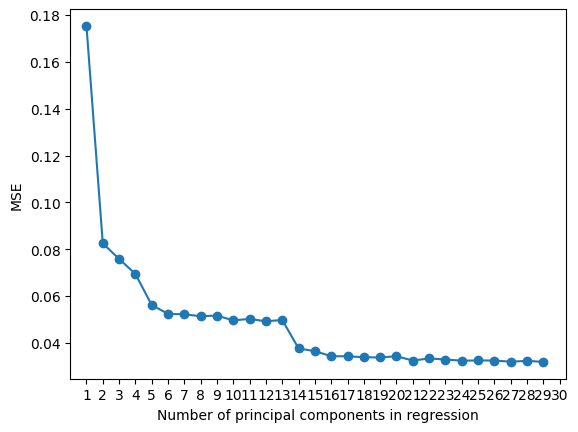

In [143]:
plt.plot(mse_list, '-o')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.xlim(xmin=-1)
plt.xticks(np.arange(30), np.arange(1, 31))
plt.show()
# plt.axhline(y=lr_score_train, color='g', linestyle='-')

In [160]:
gbm = GradientBoostingRegressor(
        learning_rate = 0.1,
        n_estimators = 300,
        min_samples_split = 3,
        min_samples_leaf = 5,
        max_depth = 5
    )
gbm.fit(x_train_pc[:,:50],y_train)
x_test_pc = pca.transform(scale(x_test))[:,:50]
-mean_squared_error(gbm.predict(x_test_pc),y_test)

-0.021690653447304916

In [163]:
d = pd.read_csv('./raw_data/train.csv')